# FFT
The point of this notebook is to get familiar with FFT. \
Custom implementations are not meant for practical use and deliberately avoid using some features of Python in order to make it easier to translate to C.

In [1]:
from __future__ import annotations

import math

import matplotlib_inline
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

from IPython.display import Audio

In [2]:
def print_result(real: list[float] | np.array, imag: list[float] | np.array) -> None:
    for r, i in zip(real, imag):
        r = round(r, 5)
        i = round(i, 5)
        print(f"{r:>10} {i:>10}")

In [3]:
simple_signal = np.arange(8, dtype=np.complex128)
simple_signal_n = len(simple_signal)
simple_signal_real = list(simple_signal.real)
simple_signal_imag = list(simple_signal.imag)

print(f"{simple_signal_real = }")
print(f"{simple_signal_imag = }")

simple_signal_real = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
simple_signal_imag = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [4]:
np_result = np.fft.fft(simple_signal)
print_result(np_result.real, np_result.imag)

      28.0        0.0
      -4.0    9.65685
      -4.0        4.0
      -4.0    1.65685
      -4.0        0.0
      -4.0   -1.65685
      -4.0       -4.0
      -4.0   -9.65685


# Recursive FFT

In [5]:
def cfft_rec(real: list[float], imag: list[float]) -> tuple[list[float], list[float]]:
    """
    Recursive implementation of 1D Cooley-Tukey radix-2 FFT algorithm for complex input.

    Input length must be power of 2. Length of both real and imag parts of the signal has to match.
    """

    n = len(real)

    if n == 1:
        return real, imag
    else:
        # Divide and recurse
        real_even, imag_even = cfft_rec(real[::2], imag[::2])
        real_odd, imag_odd = cfft_rec(real[1::2], imag[1::2])

        # Twiddle factors (can be precomputed)
        twiddles_real = [None] * n
        twiddles_imag = [None] * n
        for k in range(n):
            angle = -2 * math.pi * k / n
            twiddles_real[k] = math.cos(angle)
            twiddles_imag[k] = math.sin(angle)

        # Calculating frequency terms

        real_result = [None] * n
        imag_result = [None] * n

        # fmt: off
        for idx in range(n // 2):
            # Zero and positive terms
            real_result[idx] = real_even[idx] + twiddles_real[idx] * real_odd[idx] - twiddles_imag[idx] * imag_odd[idx]
            imag_result[idx] = imag_even[idx] + twiddles_real[idx] * imag_odd[idx] + twiddles_imag[idx] * real_odd[idx]

            # Nyquist and negative terms
            sidx = n // 2 + idx
            real_result[sidx] = real_even[idx] + twiddles_real[sidx] * real_odd[idx] - twiddles_imag[sidx] * imag_odd[idx]
            imag_result[sidx] = imag_even[idx] + twiddles_real[sidx] * imag_odd[idx] + twiddles_imag[sidx] * real_odd[idx]
        # fmt: on

        return real_result, imag_result


print_result(*cfft_rec(simple_signal_real, simple_signal_imag))

      28.0        0.0
      -4.0    9.65685
      -4.0        4.0
      -4.0    1.65685
      -4.0       -0.0
      -4.0   -1.65685
      -4.0       -4.0
      -4.0   -9.65685


# Iterative FFT

### Bit reversal

In [6]:
def int_bit_reverse(num: int, bits: int) -> int:
    """Fast bit reversal algorithm implementation for integer values."""
    res = 0
    for _ in range(bits):
        res <<= 1
        res |= num & 1
        num >>= 1
    return res


num = 6
bits = 8
reverse = int_bit_reverse(num, bits)
print(f"{num = :0>{bits}b} {reverse = :0>{bits}b}")

num = 00000110 reverse = 01100000


In [7]:
# Bit reversal is required for input reordering before iterating over butterflies
[int_bit_reverse(i, 3) for i in range(8)]

[0, 4, 2, 6, 1, 5, 3, 7]

## Butterflies

### Prepare everything for butterflies

In [8]:
# Example signal
steps = int(math.log2(simple_signal_n))

# Bit reversal permutation
brpidx = [int_bit_reverse(num, steps) for num in range(simple_signal_n)]

print(f"{brpidx = }\n")

# Bit reverse out-of-place
bit_reversed_real = [simple_signal_real[idx] for idx in brpidx]
bit_reversed_imag = [simple_signal_imag[idx] for idx in brpidx]

print(f"{bit_reversed_real = }")
print(f"{bit_reversed_imag = }\n")

# Precompute twiddle factors
twiddles_real = [None] * (simple_signal_n // 2)
twiddles_imag = [None] * (simple_signal_n // 2)
for k in range(simple_signal_n // 2):
    angle = -2 * math.pi * k / simple_signal_n
    twiddles_real[k] = round(math.cos(angle), 4)
    twiddles_imag[k] = round(math.sin(angle), 4)

print(f"{twiddles_real = }")
print(f"{twiddles_imag = }")

brpidx = [0, 4, 2, 6, 1, 5, 3, 7]

bit_reversed_real = [0.0, 4.0, 2.0, 6.0, 1.0, 5.0, 3.0, 7.0]
bit_reversed_imag = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

twiddles_real = [1.0, 0.7071, 0.0, -0.7071]
twiddles_imag = [-0.0, -0.7071, -1.0, -0.7071]


### Butterflies
Based on: https://www5.in.tum.de/lehre/vorlesungen/asc/ss13/fft.pdf \
\
I had to change how twiddle_idx is calculated. Based on attached link, it should be: `twiddles_idx = l - j -1`. \
It's possible that precomputation of the twiddle factors could be adjusted for it to work, but I couldn't get it right.

In [9]:
result_real = bit_reversed_real.copy()
result_imag = bit_reversed_imag.copy()

# fmt: off
l = 2
l_half = 1
while l <= simple_signal_n:
    m = simple_signal_n // l
    
    k = 0
    while k < simple_signal_n:
        
        j = 0
        while j < l_half:
            
            input_a_idx = k + j
            input_b_idx = k + j + l_half
            twiddles_idx = j * m

            print(f"{l = :<2} {k = :<2} {j = :<2} {input_a_idx = :<2} {input_b_idx = :<2} {twiddles_idx = :<2}")

            z_real = twiddles_real[twiddles_idx] * result_real[input_b_idx] - twiddles_imag[twiddles_idx] * result_imag[input_b_idx]
            z_imag = twiddles_real[twiddles_idx] * result_imag[input_b_idx] + twiddles_imag[twiddles_idx] * result_real[input_b_idx]

            result_real[input_b_idx] = result_real[input_a_idx] - z_real
            result_imag[input_b_idx] = result_imag[input_a_idx] - z_imag

            result_real[input_a_idx] += z_real
            result_imag[input_a_idx] += z_imag


            j += 1

        k += l

    l_half = l
    l <<= 1
# fmt: on

result_real = [round(v, 4) for v in result_real]
result_imag = [round(v, 4) for v in result_imag]

print("\nFFT result:\n")
print_result(result_real, result_imag)

l = 2  k = 0  j = 0  input_a_idx = 0  input_b_idx = 1  twiddles_idx = 0 
l = 2  k = 2  j = 0  input_a_idx = 2  input_b_idx = 3  twiddles_idx = 0 
l = 2  k = 4  j = 0  input_a_idx = 4  input_b_idx = 5  twiddles_idx = 0 
l = 2  k = 6  j = 0  input_a_idx = 6  input_b_idx = 7  twiddles_idx = 0 
l = 4  k = 0  j = 0  input_a_idx = 0  input_b_idx = 2  twiddles_idx = 0 
l = 4  k = 0  j = 1  input_a_idx = 1  input_b_idx = 3  twiddles_idx = 2 
l = 4  k = 4  j = 0  input_a_idx = 4  input_b_idx = 6  twiddles_idx = 0 
l = 4  k = 4  j = 1  input_a_idx = 5  input_b_idx = 7  twiddles_idx = 2 
l = 8  k = 0  j = 0  input_a_idx = 0  input_b_idx = 4  twiddles_idx = 0 
l = 8  k = 0  j = 1  input_a_idx = 1  input_b_idx = 5  twiddles_idx = 1 
l = 8  k = 0  j = 2  input_a_idx = 2  input_b_idx = 6  twiddles_idx = 2 
l = 8  k = 0  j = 3  input_a_idx = 3  input_b_idx = 7  twiddles_idx = 3 

FFT result:

      28.0        0.0
      -4.0     9.6568
      -4.0        4.0
      -4.0     1.6568
      -4.0        0.0


## Complete method

In [10]:
def cfft_iter(real: list[float], imag: list[float]) -> tuple[list[float], list[float]]:
    """
    Iterative implementation of 1D Cooley-Tukey radix-2 FFT algorithm for complex input.

    Input length must be power of 2. Length of both real and imag parts of the signal has to match.
    """

    n = len(real)
    log2n = int(math.log2(n))

    # Bit reversal permutation (can be precomputed)
    brpidx = [int_bit_reverse(num, log2n) for num in range(n)]

    # Bit reverse out-of-place
    _real = [real[idx] for idx in brpidx]
    _imag = [imag[idx] for idx in brpidx]

    # Twiddle factors (can be precomputed)
    twiddles_real = [None] * (n // 2)
    twiddles_imag = [None] * (n // 2)
    for k in range(n // 2):
        angle = -2 * math.pi * k / n
        twiddles_real[k] = math.cos(angle)
        twiddles_imag[k] = math.sin(angle)

    # Butterflies
    l = 2
    l_half = 1
    while l <= n:
        m = n // l

        k = 0
        while k < n:

            j = 0
            while j < l_half:

                input_a_idx = k + j
                input_b_idx = k + j + l_half
                twiddles_idx = j * m

                z_real = (
                    twiddles_real[twiddles_idx] * _real[input_b_idx]
                    - twiddles_imag[twiddles_idx] * _imag[input_b_idx]
                )
                z_imag = (
                    twiddles_real[twiddles_idx] * _imag[input_b_idx]
                    + twiddles_imag[twiddles_idx] * _real[input_b_idx]
                )

                _real[input_b_idx] = _real[input_a_idx] - z_real
                _imag[input_b_idx] = _imag[input_a_idx] - z_imag

                _real[input_a_idx] += z_real
                _imag[input_a_idx] += z_imag

                j += 1

            k += l

        l_half = l
        l <<= 1

    return _real, _imag


print_result(*cfft_iter(simple_signal_real, simple_signal_imag))

      28.0        0.0
      -4.0    9.65685
      -4.0        4.0
      -4.0    1.65685
      -4.0        0.0
      -4.0   -1.65685
      -4.0       -4.0
      -4.0   -9.65685


# RFFT (packing)
FFT can be optimised for real value signals. One way to do it is via packing. Real input is packed into complex input of half the size, complex FFT is performed on packed input and then output is untagled to get correct result. \
The result is half the size of original input, but it's Hermitian symmetric, so the other half can be easily calculated.

## Packing

In [11]:
packed_real, packed_imag = [], []
for i in range(simple_signal_n // 2):
    packed_real.append(simple_signal_real[i * 2])  # even
    packed_imag.append(simple_signal_real[i * 2 + 1])  # odd

print(f"{packed_real = }")
print(f"{packed_imag = }")

packed_real = [0.0, 2.0, 4.0, 6.0]
packed_imag = [1.0, 3.0, 5.0, 7.0]


## Complex FFT on packed input

In [12]:
packed_out_real, packed_out_imag = cfft_iter(packed_real, packed_imag)
print_result(packed_out_real, packed_out_imag)

      12.0       16.0
      -8.0       -0.0
      -4.0       -4.0
       0.0       -8.0


## Unpacking/untangling the result
Based on algorithm from: https://kovleventer.com/blog/fft_real/

In [13]:
# Twiddle factors (note that n is the length of the original input, inside CFFT it is half that)
twiddles_real = [None] * (simple_signal_n // 2)
twiddles_imag = [None] * (simple_signal_n // 2)
for k in range(simple_signal_n // 2):
    angle = -2 * math.pi * k / simple_signal_n
    twiddles_real[k] = math.cos(angle)
    twiddles_imag[k] = math.sin(angle)

In [14]:
zxr = [None] * (simple_signal_n // 2)
zxi = [None] * (simple_signal_n // 2)
for k in range(simple_signal_n // 2):
    zxr[k] = (packed_out_real[k] + packed_out_real[-k]) / 2
    zxi[k] = (packed_out_imag[k] - packed_out_imag[-k]) / 2

print(f"{zxr = }")
print(f"{zxi = }")

zxr = [12.0, -4.0, -4.0, -4.0]
zxi = [0.0, 4.0, 0.0, -4.0]


In [15]:
zyr = [None] * (simple_signal_n // 2)
zyi = [None] * (simple_signal_n // 2)
for k in range(simple_signal_n // 2):
    zyr[k] = (packed_out_imag[k] + packed_out_imag[-k]) / 2
    zyi[k] = -(packed_out_real[k] - packed_out_real[-k]) / 2

print(f"{zyr}")
print(f"{zyi}")

[16.0, -4.0, -4.0, -4.0]
[-0.0, 4.0, -0.0, -4.0]


In [16]:
# Calculate only half of the result, don't care about the symmetric part
zar = [None] * (simple_signal_n // 2)
zai = [None] * (simple_signal_n // 2)
for k in range(simple_signal_n // 2):
    zar[k] = zxr[k] + twiddles_real[k] * zyr[k] - twiddles_imag[k] * zyi[k]
    zai[k] = zxi[k] + twiddles_real[k] * zyi[k] + twiddles_imag[k] * zyr[k]

# Append Nyquist frequency
# zar.append(zxr[0] - (twiddles_real[0] * zyr[0] - twiddles_imag[0] * zyi[0]))
# zai.append(zxi[0] - (twiddles_real[0] * zyi[0] + twiddles_imag[0] * zyr[0]))

print_result(zar, zai)

      28.0        0.0
      -4.0    9.65685
      -4.0        4.0
      -4.0    1.65685


### All three steps put together

In [17]:
result_real = [None] * (simple_signal_n // 2)
result_imag = [None] * (simple_signal_n // 2)

for k in range(simple_signal_n // 2):
    yr = packed_out_imag[k] + packed_out_imag[-k]
    yi = packed_out_real[-k] - packed_out_real[k]

    # fmt: off
    result_real[k] = packed_out_real[k] + packed_out_real[-k] + twiddles_real[k] * yr - twiddles_imag[k] * yi
    result_imag[k] = packed_out_imag[k] - packed_out_imag[-k] + twiddles_real[k] * yi + twiddles_imag[k] * yr
    # fmt: on

    result_real[k] /= 2
    result_imag[k] /= 2

# Round for print
result_real = [round(v, 4) for v in result_real]
result_imag = [round(v, 4) for v in result_imag]

print_result(result_real, result_imag)

      28.0        0.0
      -4.0     9.6569
      -4.0        4.0
      -4.0     1.6569


## Complete method

In [18]:
def rfft_packing(
    real: list[float], imag: list[float]
) -> tuple[list[float], list[float]]:
    """
    Implementation of 1D Cooley-Tukey radix-2 FFT algorithm for real input.

    Input length must be power of 2. Length of both real and imag parts of the signal has to match.
    Returns list of len(real) // 2 elements. Does not calculate Nyquist frequency term.
    """

    n = len(real)

    # Pack
    _real, _imag = [], []
    for i in range(n // 2):
        _real.append(real[i * 2])
        _imag.append(real[i * 2 + 1])

    # Complex FFT
    _real, _imag = cfft_iter(_real, _imag)

    # Unpack

    # Twiddle factors
    twiddles_real = [None] * (n // 2)
    twiddles_imag = [None] * (n // 2)
    for k in range(n // 2):
        angle = -2 * math.pi * k / n
        twiddles_real[k] = math.cos(angle)
        twiddles_imag[k] = math.sin(angle)

    result_real = [None] * (n // 2)
    result_imag = [None] * (n // 2)

    for k in range(n // 2):
        yr = _imag[k] + _imag[-k]
        yi = _real[-k] - _real[k]

        result_real[k] = (
            _real[k] + _real[-k] + twiddles_real[k] * yr - twiddles_imag[k] * yi
        )
        result_imag[k] = (
            _imag[k] - _imag[-k] + twiddles_real[k] * yi + twiddles_imag[k] * yr
        )

        result_real[k] /= 2
        result_imag[k] /= 2

    return result_real, result_imag


print_result(*rfft_packing(simple_signal_real, simple_signal_imag))

      28.0        0.0
      -4.0    9.65685
      -4.0        4.0
      -4.0    1.65685


# RFFT (Sorensen)
https://github.com/belangeo/pyo/blob/master/src/engine/fft.c

In [19]:
# TODO

# Performance comparison
The comparison isn't comprehensive, but it should be noted that packing significantly improves performance of iterative CFFT.

In [20]:
performance_inp_size = 2**11
performance_inp_real = list(range(performance_inp_size))
performance_inp_imag = [0] * performance_inp_size

In [21]:
%timeit cfft_rec(performance_inp_real, performance_inp_imag)

14.8 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit cfft_iter(performance_inp_real, performance_inp_imag)

8.25 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit rfft_packing(performance_inp_real, performance_inp_imag)

4.58 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Practical example

Samples: 1639
Samples after truncating: 1024


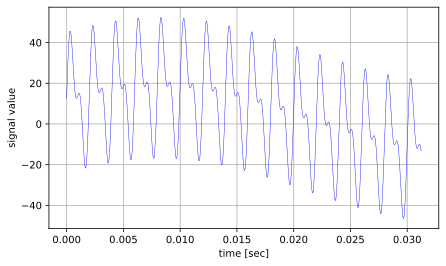

In [24]:
# Construct signal
signal_params = [
    {"frequency": 1, "amplitude": 10, "phase": np.pi},
    {"frequency": 20, "amplitude": 15, "phase": 0.5},
    {"frequency": 500, "amplitude": 25, "phase": 0},
    {"frequency": 1000, "amplitude": 15, "phase": 0.1},
]
sampling_rate = 2**15
duration = 0.05

time_step = 1 / sampling_rate
time_axis = np.arange(0, duration, time_step)

signal = np.sum(
    [
        params["amplitude"]
        * np.sin(2 * np.pi * params["frequency"] * time_axis + params["phase"])
        + 1
        for params in signal_params
    ],
    axis=0,
)
n = len(signal)
print(f"Samples: {n}")

# Truncate to power of 2
n = 2 << int(math.log2(n) - 1)
print(f"Samples after truncating: {n}")
signal = signal[:n]
time_axis = time_axis[:n]

# Extract
signal_real = list(signal.real)
signal_imag = list(signal.imag)

# Plot
ax = plt.figure(figsize=(7, 4)).gca()
ax.plot(time_axis, signal, "b", linewidth=0.4)
ax.set_xlabel("time [sec]")
ax.set_ylabel("signal value")
ax.grid(True)

plt.show()

Audio(signal, rate=sampling_rate)

In [25]:
rfft_real, rfft_imag = rfft_packing(signal_real, signal_imag)

# Frequency values to map to fft results

In [26]:
def get_rfft_freq(n: int, sampling_rate: int) -> list[float]:
    """Get a list of n // 2 - 1 frequency values matching rfft result."""
    return [i * sampling_rate / n for i in range(n // 2)]


rfft_freq = get_rfft_freq(n, sampling_rate)
print(
    "["
    + ", ".join(map(str, rfft_freq[:5]))
    + ", ..., "
    + ", ".join(map(str, rfft_freq[-5:]))
    + "]"
)

[0.0, 32.0, 64.0, 96.0, 128.0, ..., 16224.0, 16256.0, 16288.0, 16320.0, 16352.0]


# Amplitude and power spectrums (normalized)

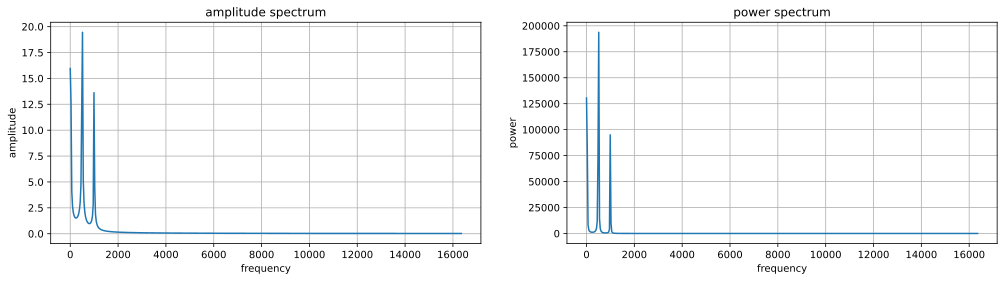

In [27]:
# Two ways to combine fft result into something more usefull


def amplitude(a: float, b: float) -> float:
    return (a**2 + b**2) ** 0.5


def power(a: float, b: float) -> float:
    return a**2 + b**2


norm = n / 2
amplitude_spectrum = [
    amplitude(real, imag) / norm for real, imag in zip(rfft_real, rfft_imag)
]
power_spectrum = [power(real, imag) / norm for real, imag in zip(rfft_real, rfft_imag)]

fig = plt.figure(figsize=(17, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(rfft_freq, amplitude_spectrum)
ax.set_title("amplitude spectrum")
ax.set_xlabel("frequency")
ax.set_ylabel("amplitude")
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(rfft_freq, power_spectrum)
ax.set_title("power spectrum")
ax.set_xlabel("frequency")
ax.set_ylabel("power")
ax.grid(True)

# Mel scale (bucketing frequencies)

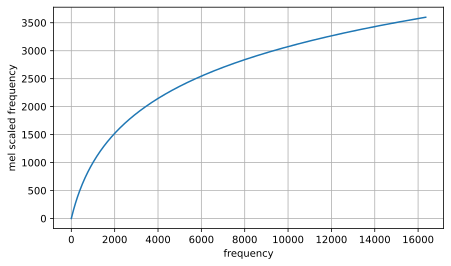

In [28]:
def freq_to_mel(frequency: float) -> float:
    return 2595 * math.log10(1 + frequency / 700)


def mel_to_freq(mel: float) -> float:
    return 700 * (10 ** (mel / 2595) - 1)


mel_scaled_frequencies = [freq_to_mel(freq) for freq in rfft_freq]

ax = plt.figure(figsize=(7, 4)).gca()
ax.plot(rfft_freq, mel_scaled_frequencies)
ax.set_xlabel("frequency")
ax.set_ylabel("mel scaled frequency")
ax.grid(True)

In [29]:
n_bins = 16

In [30]:
def get_mel_thresholds(max_frequency: float, n_bins: int) -> float:
    """
    Calculate frequency thresholds that divide max_frequency into n_bins based on Mel scale.
    """
    mel_step = freq_to_mel(max_frequency) / n_bins
    thresholds = [mel_to_freq(mel_step * i) for i in range(1, n_bins + 1)]

    return thresholds


mel_thresholds = get_mel_thresholds(rfft_freq[-1], n_bins)
mel_thresholds

[154.60488363512792,
 343.35643876144377,
 573.7964399109787,
 855.132369007089,
 1198.605310360749,
 1617.9391004712622,
 2129.888678902223,
 2754.909550190858,
 3517.975105872501,
 4449.574463614336,
 5586.930693210796,
 6975.48810499075,
 8670.728026869187,
 10740.38562139853,
 13267.156318166115,
 16351.999999999996]

In [31]:
def get_mel_split(frequencies: list[float], n_bins: int) -> list[int]:
    """
    Calculate how to split a sorted (ascending) list of frequencies into n bins based on Mel scale.

    Returns a list with counts of how many frequencies should be used to create a bin.
    Note that in order for this bucketing to work well, there has to be enough frequencies.
    """
    freq_thresholds = get_mel_thresholds(frequencies[-1], n_bins)

    bin_sizes = [0] * n_bins

    fidx = 0
    tidx = 0

    while tidx < len(freq_thresholds):
        while fidx < len(frequencies):

            if frequencies[fidx] < freq_thresholds[tidx]:
                bin_sizes[tidx] += 1
            else:
                break

            fidx += 1
        tidx += 1

    return bin_sizes


bin_sizes = get_mel_split(rfft_freq, n_bins)
bin_sizes

[5, 6, 7, 9, 11, 13, 16, 20, 23, 30, 35, 43, 53, 65, 79, 96]

In [32]:
bins = [0] * n_bins

aidx = 0
bin_size = 0
for bidx in range(n_bins):
    while aidx < len(amplitude_spectrum):

        if bin_size >= bin_sizes[bidx]:
            bin_size = 0
            break

        bin_size += 1
        bins[bidx] = max(bins[bidx], amplitude_spectrum[aidx])
        aidx += 1


bins

[15.96049111233227,
 1.746923426893671,
 19.451104317038325,
 2.995295850628594,
 13.619093460560999,
 0.5035530255337062,
 0.21276467390085974,
 0.13724899196629164,
 0.09827728856111785,
 0.07529642074468619,
 0.058457795912718685,
 0.04695729652199874,
 0.03841099654551086,
 0.03206553902100801,
 0.027534646752337646,
 0.02465894033369396]